In [1]:
import torch
import torch.nn as nn
import torchvision.utils
import enum
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint, model_parameters

/usr/scratch/abhimanyu/work/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Amir
class SparseType(str, enum.Enum):
  """Pruning types dataclass."""
  DENSE = 'DENSE'
  STRUCTURED_NM = 'STRUCTURED_NM'
  UNSTRUCTURED = 'UNSTRUCTURED'
  SRSTE = 'SRSTE'

def restricted_float(x, min_value, max_value):
    try:
        x = float(x)
    except ValueError:
        raise argparse.ArgumentTypeError("%r not a floating-point literal" % (x,))

    if x <= min_value or x >= max_value:
        raise argparse.ArgumentTypeError("%r not in range (0.0, 1.0)"%(x,))
    return x
# Rima
#Abhi
class DecayType(str,enum.Enum):
    """Pruning decay type dataclass."""
    STEP = 'STEP'
    LINEAR = 'LINEAR'
    EXP = 'EXP'

class StructureDecayType(str,enum.Enum):
    SPARSIFY = 'SPARSIFY'       ##  Dense -> 7:8    -> 4:8  -> 2:8  -> 1:8
    DENSIFY = 'DENSIFY'         ##  Dense -> 1:128  -> 1:32 -> 1:16 -> 1:8
    FINE = 'FINE'               ##  Dense -> 16:128 -> 8:64 -> 4:32 -> 2:16 -> 1:8
    CONFIG = 'CONFIG'           ##  Get a user defined config


class SparseDimType(str,enum.Enum):
    """Pruning dimension dataclass."""
    ROW = 0
    COL = 1

class Sparstiy_Args:
    n_sparsity = 2
    m_sparsity = 4
    sparsity_type = 'DENSE'
    prune_rate = 0
    decay_type = 'STEP'
    structure_decay_type = 'SPARSIFY'
    structure_decay_config = None
    decay_coef = 0.0002
    structure_decay_flag = False
    dense_epochs = 0
    fine_tune_epochs = 100 
    total_epochs = 0
    sparsity_loc = 'FF'
    n_sparsity_qkv = 2
    m_sparsity_qkv = 2
    prune_rate_qkv = 0
    sparse_dim = 0

    def __str__(self):
        a = f"N: {self.n_sparsity} | M: {self.m_sparsity} | Type: {self.sparsity_type}\n"
        if("Q" in self.sparsity_loc or "V" in self.sparsity_loc or "K" in self.sparsity_loc):
            b = f"Prune Rate: {self.prune_rate} | Decay: {self.decay_type} | Location: {self.sparsity_loc} | QKV rate : {self.n_sparsity_qkv}:{self.m_sparsity_qkv} , {self.prune_rate_qkv}\n"
        else:
            b = f"Prune Rate: {self.prune_rate} | Decay: {self.decay_type} | Location: {self.sparsity_loc}\n"
        c = f"Decay Coeff: {self.decay_coef} | Structure Decay: {self.structure_decay_flag} | Type: {self.structure_decay_type} | Sparse Dim: {self.sparse_dim}\n"
        d = f"Dense epochs: {self.dense_epochs} | Fine tune epochs: {self.fine_tune_epochs} | total epochs: {self.total_epochs}. Distribution:{self.dense_epochs/self.total_epochs}:{(self.total_epochs-self.dense_epochs-self.fine_tune_epochs)/self.total_epochs}:{self.fine_tune_epochs/self.total_epochs}"
        return a + b + c + d



sparseConfig = Sparstiy_Args()

In [3]:
model_initial = create_model(
        "vit_ultra_tiny_patch16_224",
        pretrained=False,
        in_chans=3,
        num_classes=1000,
        sparseConfig=sparseConfig
    )

model_final = create_model(
        "vit_ultra_tiny_patch16_224",
        pretrained=False,
        in_chans=3,
        num_classes=1000,
        sparseConfig=sparseConfig
    )

No pretrained configuration specified for vit_ultra_tiny_patch16_224 model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
No pretrained configuration specified for vit_ultra_tiny_patch16_224 model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


Dense qkv
Dense linear
Dense linear
Dense qkv
Dense linear
Dense linear
Dense qkv
Dense linear
Dense linear
Dense qkv
Dense linear
Dense linear
Dense qkv
Dense linear
Dense linear
Dense qkv
Dense linear
Dense linear


In [4]:
file_name = "/usr/scratch/abhimanyu/work/pytorch-image-models-sparsity/"
file_name +="vit_small_vis/20230505-001604-vit_ultra_tiny_patch16_224-224/checkpoint-0.pth.tar"
model_initial.load_state_dict(torch.load(file_name)['state_dict'])

<All keys matched successfully>

In [5]:
file_name = "/usr/scratch/abhimanyu/work/pytorch-image-models-sparsity/"
file_name +="vit_small_vis/20230505-014731-vit_ultra_tiny_patch16_224-224/checkpoint-350.pth.tar"
model_final.load_state_dict(torch.load(file_name)['state_dict'])

<All keys matched successfully>

In [6]:
# for var_name in model_initial.state_dict():
#     print(var_name, ":", model_initial.state_dict()[var_name].shape)


In [7]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt


def vistensor(model): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    num_blocks = 0
    tensor_fc1 = []
    tensor_fc2 = []
    for weight in model.state_dict():
        if('fc1' in weight and 'weight' in weight ):
            num_blocks +=1
            tensor_fc1.append(model.state_dict()[weight])
        if('fc2' in weight and 'weight' in weight ):
            num_blocks +=1
            tensor_fc2.append(model.state_dict()[weight])
    
    x = [tensor_fc1 , tensor_fc2]
    print(len(x[0]),len(x[1]))
    
    return   x     
    # plt.imshow(grid)




In [49]:
import csv
import os
from collections import OrderedDict

def get_sparse_weights(weight,N=2,M=4):
    length = weight.numel()
    
    group = int(length/M)

    weight_temp = weight.detach().abs().reshape(group, M)
    index = torch.argsort(weight_temp, dim=1)[:, :int(M-N)]

    w_b = torch.ones(weight_temp.shape, device=weight_temp.device)
    w_b = w_b.scatter_(dim=1, index=index, value=0).reshape(weight.shape)

    return w_b*weight

def update_model_stats(
        step,
        model,
        filename,

):
    rowd = OrderedDict(step_num=step)
    for weight in model.state_dict():
        if('fc' in weight and 'weight' in weight):
            weight_matrix = model.state_dict()[weight] 
            rowd.update({f'mean_' + str(weight) : torch.mean(weight_matrix).numpy()})
            rowd.update({f'std_' + str(weight) :  torch.std(weight_matrix).numpy()})
            sparse_weight_matrix = get_sparse_weights(weight_matrix)
            rowd.update({f'mean_sparse_' + str(weight) : torch.mean(sparse_weight_matrix).numpy()})
            rowd.update({f'std_sparse_' + str(weight) :  torch.std(sparse_weight_matrix).numpy()})

    with open(filename, mode='a') as cf:
        dw = csv.DictWriter(cf, fieldnames=rowd.keys())
        # Get the size of the file
        file_size = os.path.getsize(filename)
    
        # Check if the file is empty
        if file_size == 0:
            dw.writeheader()
        dw.writerow(rowd)


In [53]:


update_model_stats( 10, model_initial,  'test_2.csv')

3 3
Mean:6.160187695058994e-06, STD:0.018739521503448486


(array([[ 0.,  5., 33., ..., 17.,  0.,  0.],
        [ 0.,  6., 34., ..., 24.,  1.,  0.],
        [ 0.,  2., 33., ..., 24.,  2.,  0.],
        ...,
        [ 0.,  5., 34., ..., 33.,  3.,  1.],
        [ 2.,  5., 33., ..., 25.,  0.,  1.],
        [ 0.,  7., 42., ..., 16.,  0.,  0.]]),
 array([-0.08459801, -0.06727611, -0.04995419, -0.03263228, -0.01531038,
         0.00201153,  0.01933344,  0.03665535,  0.05397726,  0.07129917,
         0.08862108], dtype=float32),
 <a list of 192 BarContainer objects>)

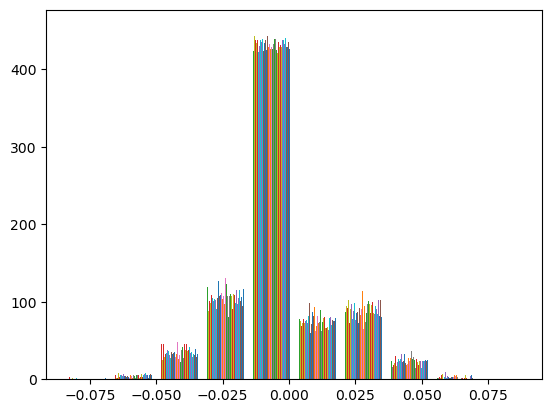

In [21]:
tensor_initial = vistensor(model_initial)
sparse_weight = get_sparse_weights(tensor_initial[1][0],2,4)
mean = torch.mean(sparse_weight)
std = torch.std(sparse_weight)
print(f"Mean:{mean}, STD:{std}")
plt.hist(sparse_weight)

3 3
Mean:-4.786805675394135e-06, STD:0.018847813829779625


(array([[ 0.,  2., 16., ..., 27.,  1.,  0.],
        [ 0.,  0., 19., ..., 25.,  1.,  0.],
        [ 0.,  0., 11., ..., 18.,  0.,  0.],
        ...,
        [ 0.,  2., 19., ..., 27.,  4.,  0.],
        [ 1.,  2., 16., ..., 18.,  0.,  1.],
        [ 0.,  1., 17., ..., 18.,  1.,  0.]]),
 array([-0.09878854, -0.07951824, -0.06024795, -0.04097765, -0.02170735,
        -0.00243705,  0.01683325,  0.03610355,  0.05537384,  0.07464414,
         0.09391444], dtype=float32),
 <a list of 192 BarContainer objects>)

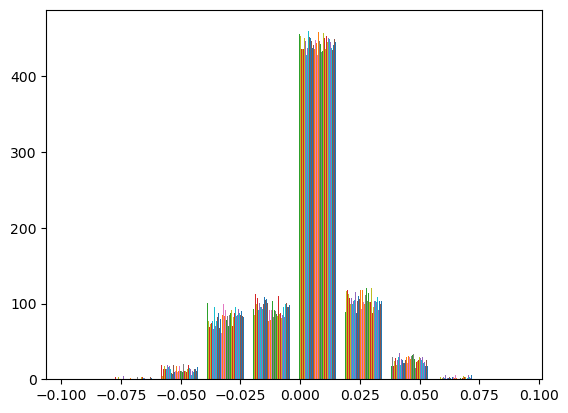

In [24]:
tensor_final = vistensor(model_final)
sparse_weight1 = get_sparse_weights(tensor_final[1][0])
mean1 = torch.mean(sparse_weight1)
std1 = torch.std(sparse_weight1)
print(f"Mean:{mean1}, STD:{std1}")
plt.hist(sparse_weight1)

Mean:1.0947002010652795e-05, STD:0.01449041161686182


(array([[ 0.,  2., 25., ..., 14.,  2.,  0.],
        [ 0.,  0.,  9., ..., 12.,  2.,  0.],
        [ 0.,  1., 13., ..., 11.,  0.,  0.],
        ...,
        [ 0.,  3., 33., ..., 13.,  0.,  0.],
        [ 0.,  0., 23., ..., 10.,  0.,  1.],
        [ 0.,  2., 17., ...,  7.,  0.,  0.]]),
 array([-0.07672289, -0.06070689, -0.0446909 , -0.0286749 , -0.01265891,
         0.00335709,  0.01937308,  0.03538908,  0.05140507,  0.06742106,
         0.08343706], dtype=float32),
 <a list of 192 BarContainer objects>)

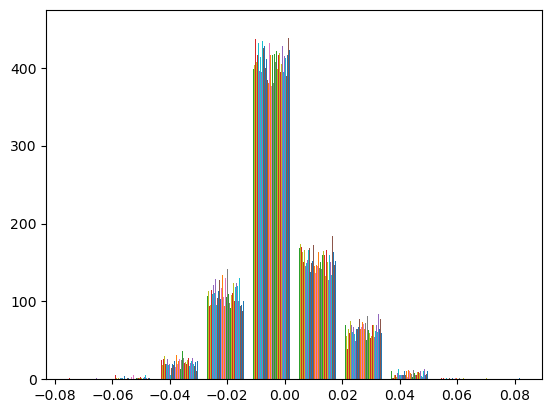

In [23]:
diff = (sparse_weight - sparse_weight1)

mean_diff = torch.mean(diff)
std_diff = torch.std(diff)

print(f"Mean:{mean_diff}, STD:{std_diff}")
plt.hist(diff)

3 3
tensor(147456)
tensor(147456)
tensor(147456)


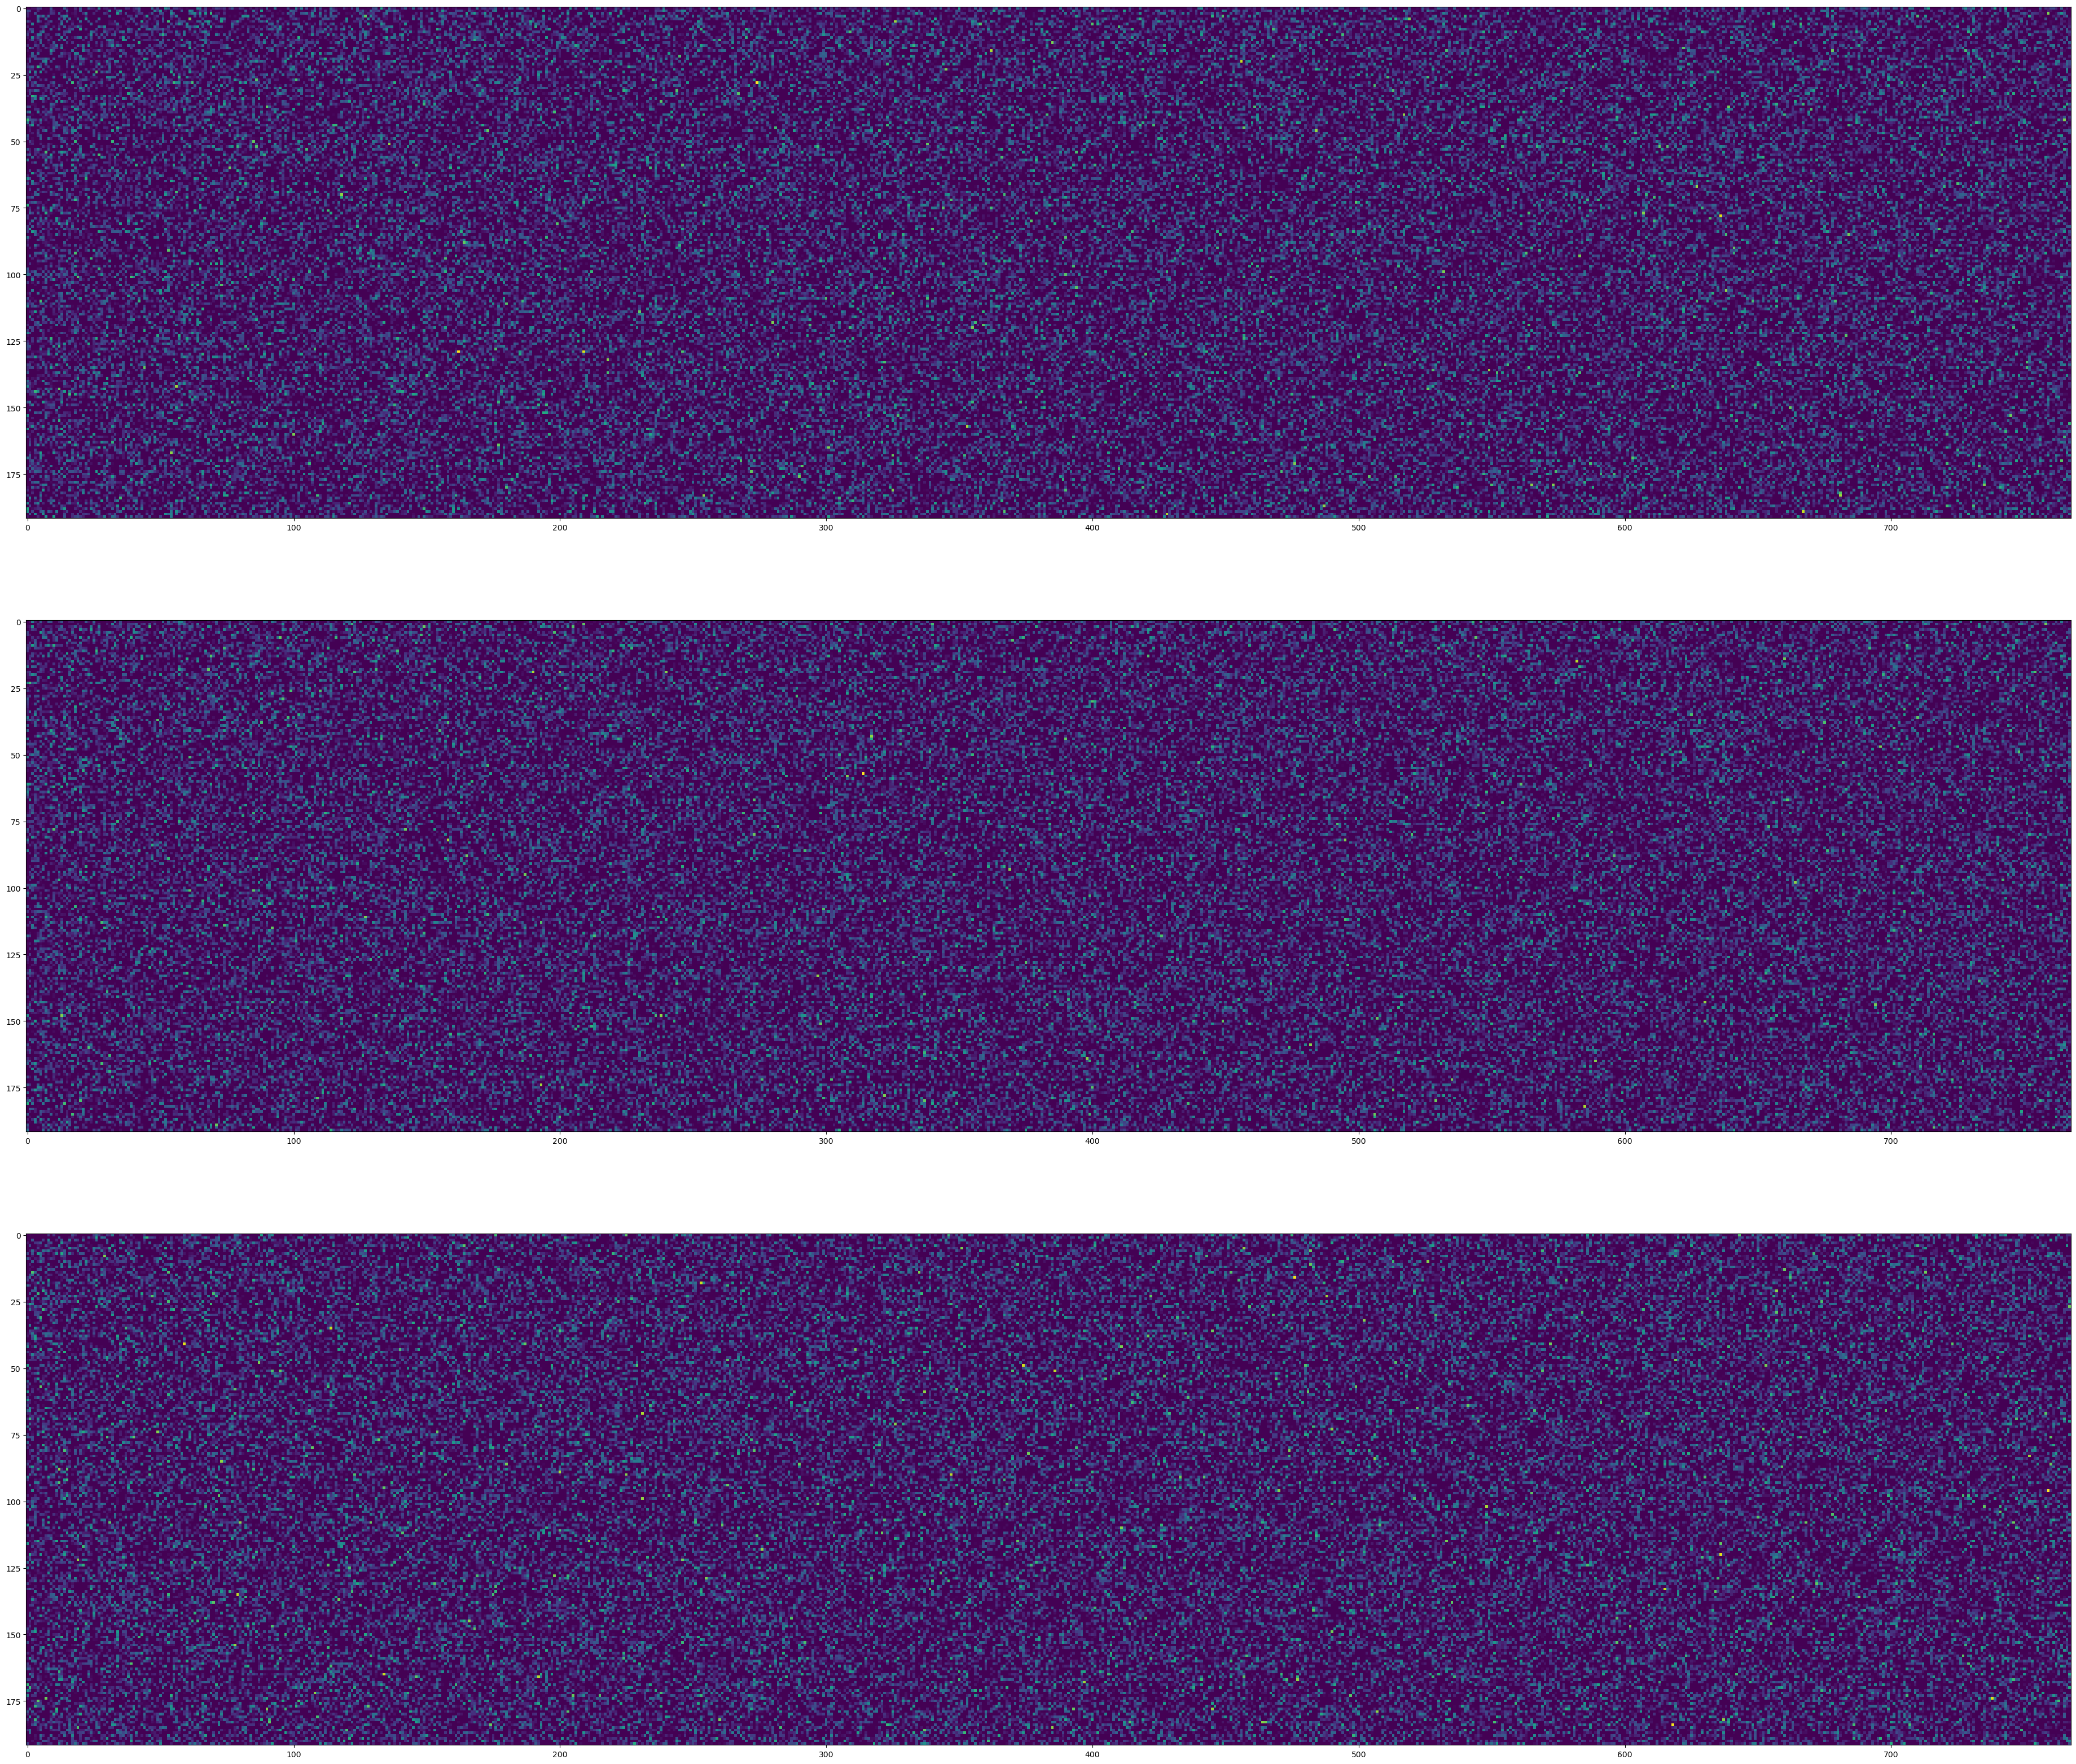

In [9]:
tensor_initial = vistensor(model_initial)
fig, axs = plt.subplots(nrows=3, ncols=1 , figsize = [48,40])

# plot each image in a subplot
for i in range(3):
    for j in range(1):
        # plt.figure(figsize=(4,6))
        axs[i].imshow(tensor_initial[1][i]/ torch.max(tensor_initial[1][i]), vmin = 0, vmax = 1)
        print(torch.count_nonzero(tensor_initial[1][i]))
        # plt.show()

# display the figure
plt.show()

3 3
tensor(147456)
tensor(147456)
tensor(147456)


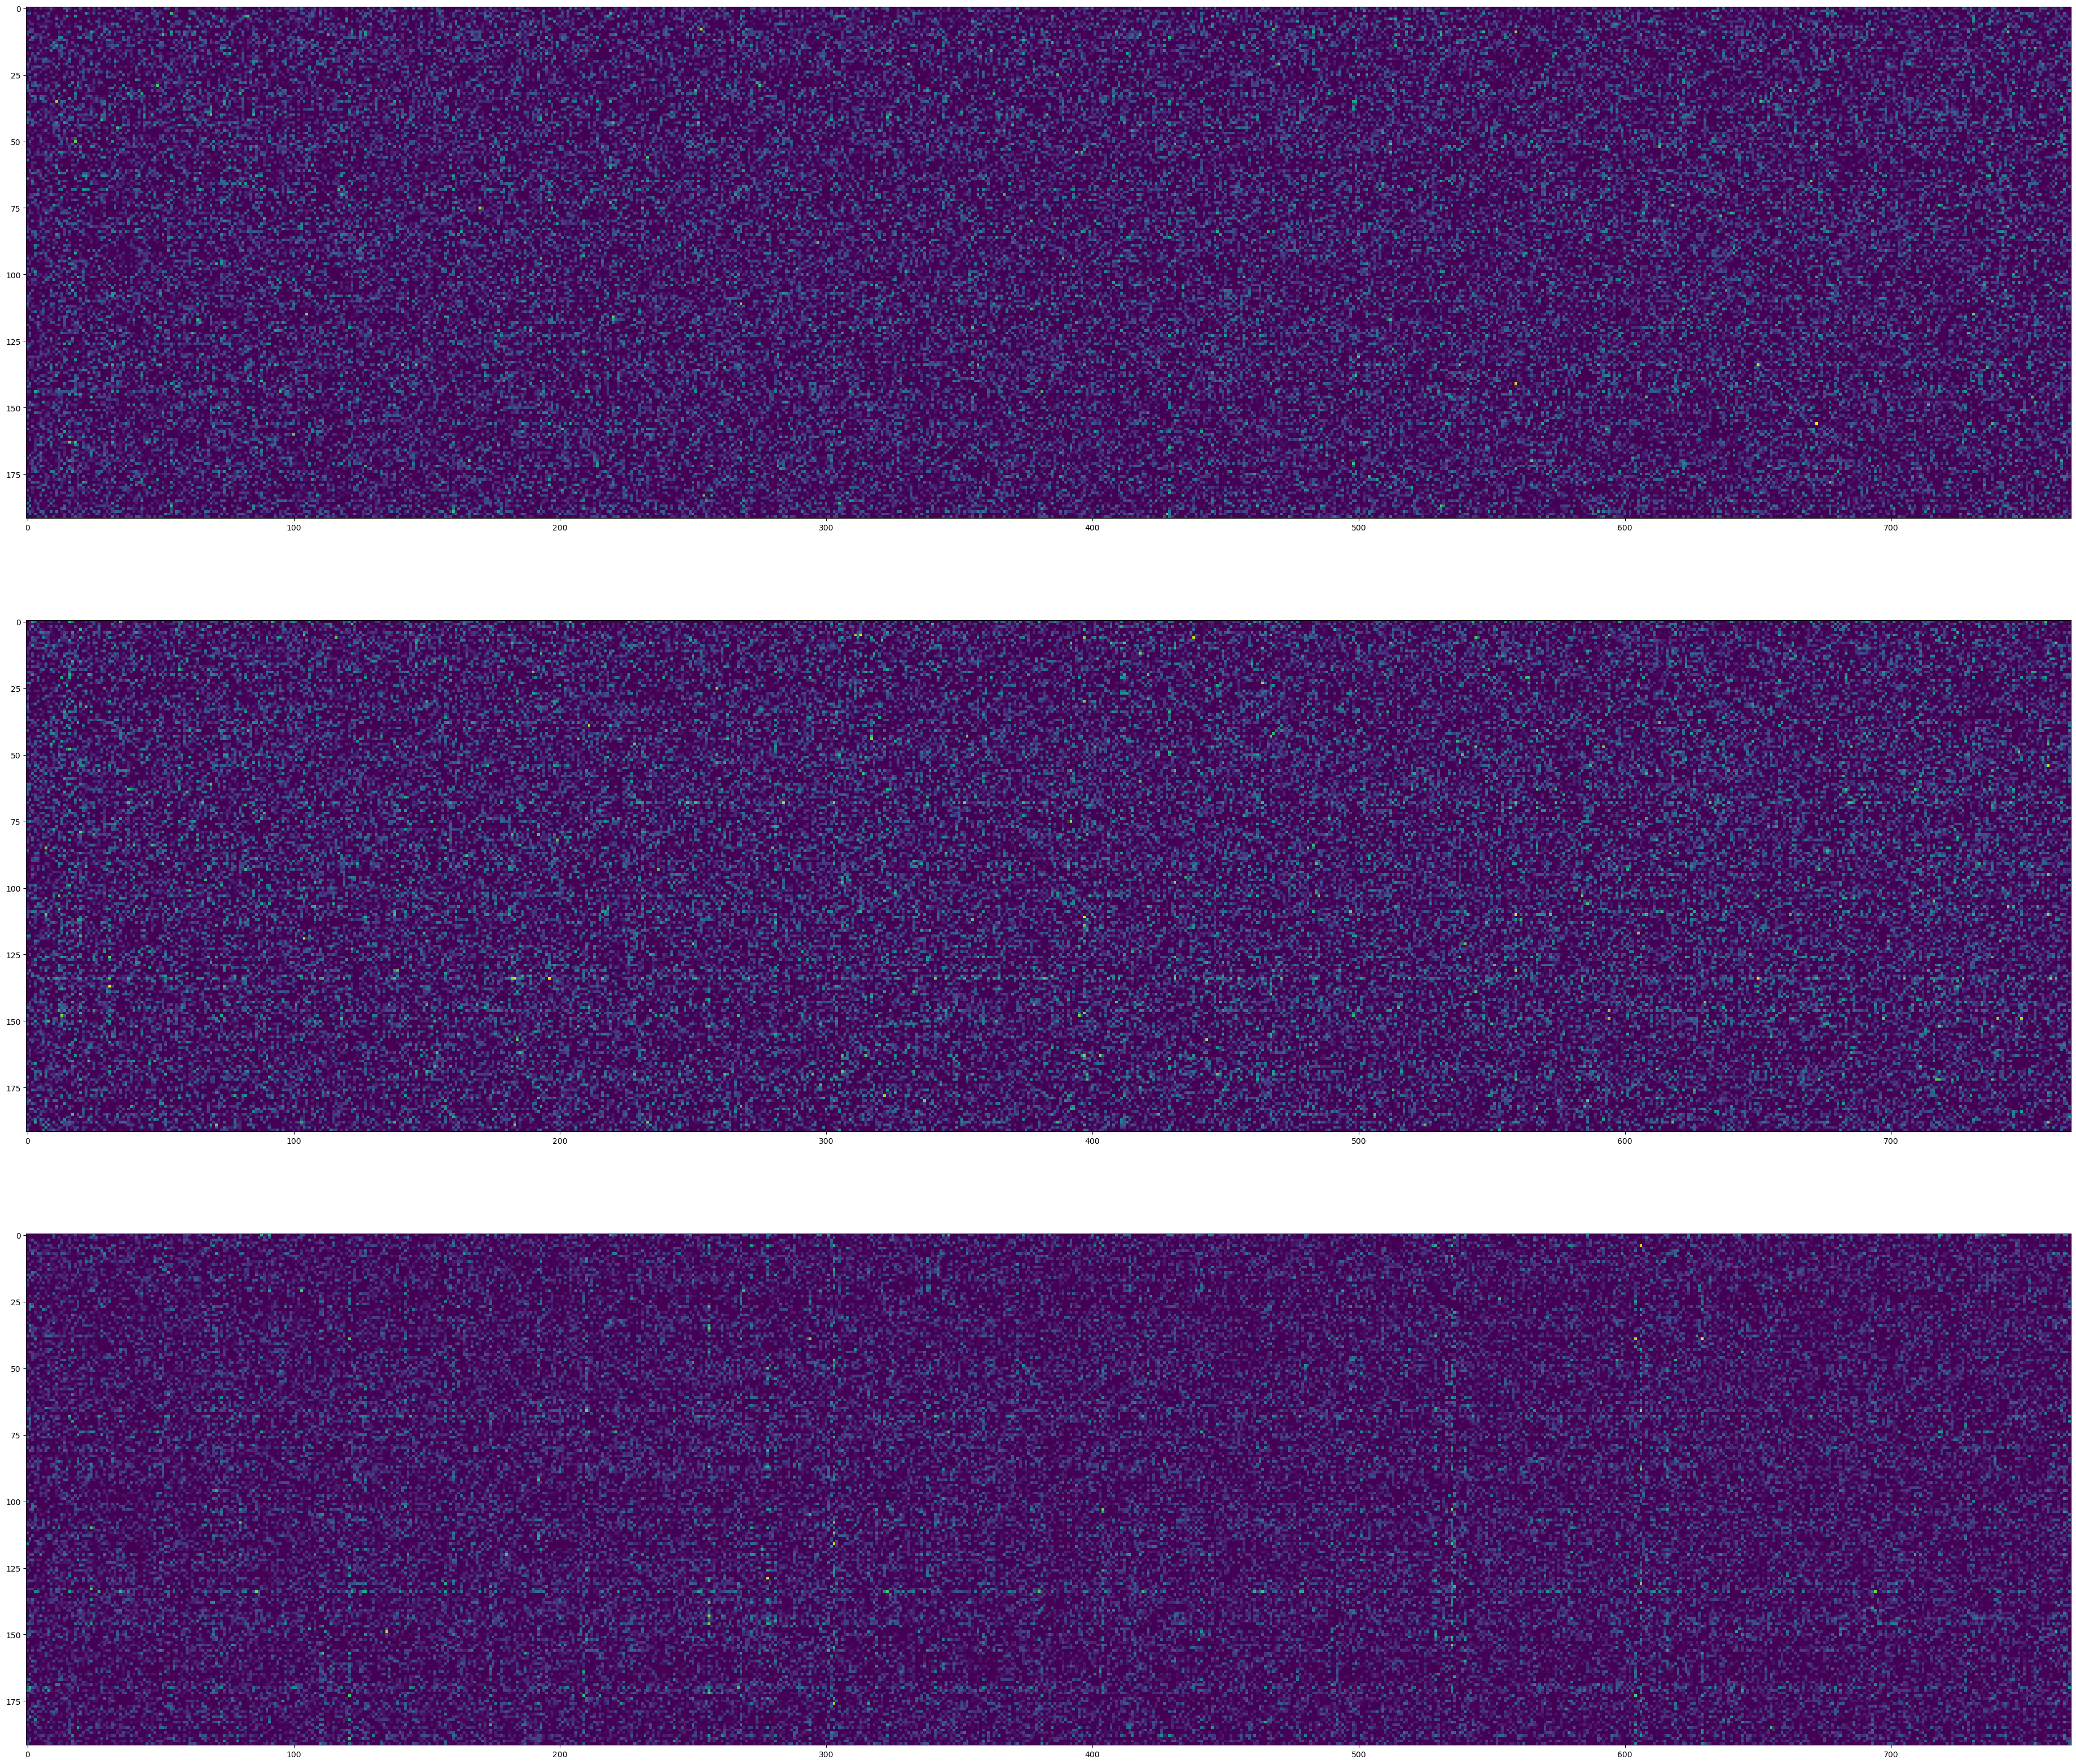

In [10]:
tensor_final = vistensor(model_final)
fig, axs = plt.subplots(nrows=3, ncols=1 , figsize = [48,40])

# plot each image in a subplot
for i in range(3):
    for j in range(1):
        # plt.figure(figsize=(4,6))
        axs[i].imshow(tensor_final[1][i]/ torch.max(tensor_final[1][i]), vmin = 0, vmax = 1)
        print(torch.count_nonzero(tensor_final[1][i]))
        # plt.show()

# display the figure
plt.show()